# Using all the available data
## Imports & global variables

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import sys; sys.path.append("/data/miguel/practicum/DL-Medical-Physics")
import warnings; warnings.filterwarnings('ignore')

from core import *
from data_manipulation import DataBatches, RandomRotation, Flip, RandomCrop, balance_obs, multi_label_2_binary
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import get_optimizer, FinderPolicy, OptimizerWrapper, validate_binary, lr_finder, TTA_binary

BATCH_SIZE = 16
EPOCHS = 20
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]
PRETRAINED = False
FREEZE = False
GRADUAL_UNFREEZING = False

BASE_PATH = Path('/data/miguel/practicum/')
PATH = BASE_PATH/'data'
# SAVE_DATA = BASE_PATH/'output/real_data_experiments/multilabel/results'
# SAVE_DIRECTORY = BASE_PATH/'output/real_data_experiments/multilabel/models'
# SAVE_PLOT = Path('../latest_plots/14diseases-app1')

IMG_FOLDER = PATH/'ChestXRay-250'
DATA = 'Pneumonia'
DISEASE = 'Emphysema'

idx2tgt = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

tgt2idx = {disease: i for i, disease in enumerate(idx2tgt)}

## Data Batches

In [2]:
# data preparation
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

train_df = multi_label_2_binary(train_df, tgt2idx[DISEASE])

valid_df = multi_label_2_binary(valid_df, tgt2idx[DISEASE])
valid_df = balance_obs(valid_df, amt=2*len(valid_df[valid_df['Label']==1]))

test_df = multi_label_2_binary(test_df, tgt2idx[DISEASE])
test_df = balance_obs(test_df, amt=2*len(test_df[test_df['Label']==1]))


train_dl = DataBatches(train_df, img_folder_path=IMG_FOLDER,transforms=TRANSFORMATIONS, 
                       shuffle=True, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)

valid_dl = DataBatches(valid_df,img_folder_path=IMG_FOLDER, transforms = False,
                       shuffle = False, data=DATA, batch_size = BATCH_SIZE, normalize=PRETRAINED)

test_dl = DataBatches(test_df,img_folder_path=IMG_FOLDER, transforms = TRANSFORMATIONS, 
                      shuffle = False, data=DATA, batch_size = BATCH_SIZE, normalize=PRETRAINED)

## LR Finder

A Jupyter Widget

A Jupyter Widget

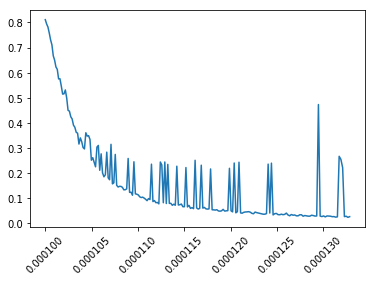

In [3]:
sampled_df = balance_obs(train_df, amt=2000)

model = DenseNet121(1, pretrained=PRETRAINED, freeze=FREEZE).cuda()
lrs, losses  = lr_finder(model, 1, train_dl)

## Training & Testing

In [4]:
# training loop: definition
def regular_training(epochs, train_dl, valid_dl, model, save_path=None,
          min_lr=1e-6, max_lr=0.001, epsilon=.001, unfreeze_during_loop:tuple=None):
    lr = max_lr
    prev_loss, min_loss = np.inf, np.inf
    cnt = 0
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])
        
    
    for epoch in tqdm_notebook(range(epochs)):
        model.train()
        train_dl.set_random_choices()
        total = 0
        sum_loss = 0
        optim = get_optimizer(model, lr=lr, wd=0)
        for x, y in tqdm_notebook(train_dl, leave=False):
            
            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)
            
            batch = y.shape[0]
            out = model(x).squeeze()
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            total += batch
            sum_loss += batch * (loss.item())
            
            cnt += 1
                
        val_loss, measure, _ = validate_binary(model, valid_dl)
        print(f'Ep. {epoch+1} - lr {lr:.7f} train loss {sum_loss/total:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if val_loss - prev_loss > epsilon:
            lr = lr / 10.0
        if val_loss < min_loss:
            if save_path: save_model(model, save_path)
            min_loss = val_loss
        prev_loss = val_loss
        if lr < min_lr:
            break

In [5]:
def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

class TrainingPolicy:
    '''Cretes the lr and momentum policy'''

    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):
        
        total_iterations = n_epochs * len(dl)

        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)

        min_start = max_lr / div_factor
        min_end = min_start * delta

        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
    
def one_cycle_train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in tqdm_notebook(train_dl, leave=False):

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x).squeeze()
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_binary(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

In [6]:
# training loop: execution


transforms=[RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]

sampled_df = balance_obs(train_df, amt=2000)

train_dl = DataBatches(sampled_df, img_folder_path=IMG_FOLDER,transforms=TRANSFORMATIONS,
                       shuffle=True, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)


model = DenseNet121(1, pretrained=PRETRAINED, freeze=FREEZE).cuda()
save_path = None
regular_training(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=save_path)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - lr 0.0010000 train loss 0.7048 -  val loss 0.6644 AUC 0.6483


A Jupyter Widget

Ep. 2 - lr 0.0010000 train loss 0.7030 -  val loss 0.6573 AUC 0.6729


A Jupyter Widget

Ep. 3 - lr 0.0010000 train loss 0.6922 -  val loss 0.9214 AUC 0.5385


A Jupyter Widget

Ep. 4 - lr 0.0001000 train loss 0.6793 -  val loss 0.6545 AUC 0.6667


A Jupyter Widget

Ep. 5 - lr 0.0001000 train loss 0.6720 -  val loss 0.6514 AUC 0.6724


A Jupyter Widget

KeyboardInterrupt: 

In [8]:
# load_model(model, save_path)
# test_dl = DataBatches(test_df,img_folder_path=IMG_FOLDER, transforms = TRANSFORMATIONS, 
#                       shuffle = False, data=data, batch_size = BATCH_SIZE, normalize=PRETRAINED)
# TTA_multilabel(model, test_dl)

In [11]:
model = DenseNet121(1, pretrained=PRETRAINED, freeze=FREEZE).cuda()
save_path = None
one_cycle_train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if GRADUAL_UNFREEZING else None, alpha=1)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.6884 -  val loss 0.7046 AUC 0.5025


A Jupyter Widget

Ep. 2 - train loss 0.6829 -  val loss 0.6728 AUC 0.6634


A Jupyter Widget

Ep. 3 - train loss 0.6849 -  val loss 0.6429 AUC 0.6830


A Jupyter Widget

Ep. 4 - train loss 0.6918 -  val loss 0.6727 AUC 0.6699


A Jupyter Widget

Ep. 5 - train loss 0.6870 -  val loss 0.6961 AUC 0.6761


A Jupyter Widget

Ep. 6 - train loss 0.6767 -  val loss 0.7312 AUC 0.6776


A Jupyter Widget

KeyboardInterrupt: 

In [ ]:
# load_model(model, save_pathc)
# test_dl = DataBatches(test_df,img_folder_path=IMG_FOLDER, transforms = TRANSFORMATIONS, 
#                       shuffle = False, data=DATA, batch_size = BATCH_SIZE, normalize=PRETRAINED)
# TTA_multilabel(model, test_dl)

# Sample range: Writing script

We will train the different combinations on a script. Observe that we have constructed the training function 

In [11]:
! pwd

/data/miguel/practicum/DL-Medical-Physics/training_methods


In [2]:
%%writefile emphysema.py

import sys; sys.path.append("/data/miguel/practicum/DL-Medical-Physics")

from core import *
from data_manipulation import DataBatches, RandomRotation, Flip, RandomCrop, balance_obs, multi_label_2_binary
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import get_optimizer, FinderPolicy, OptimizerWrapper, validate_binary, TTA_binary
import json

BATCH_SIZE = 16
EPOCHS = 10
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]
DATA = 'Pneumonia'
DISEASE = 'Emphysema'

idx2tgt = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

tgt2idx = {disease: i for i, disease in enumerate(idx2tgt)}

SAMPLE_AMOUNTS = [50,100,200,400,600,800,1000,1200,1400,1600,1800,2000]

BASE_PATH = Path('/data/miguel/practicum/')
PATH = BASE_PATH/'data'
SAVE_DIRECTORY = BASE_PATH/'DL-Medical-Physics/training_methods/models'
SAVE_DATA = BASE_PATH/'DL-Medical-Physics/training_methods/results'
IMG_FOLDER = PATH/'ChestXRay-250'
PRETRAINED = False
FREEZE = False
GRADUAL_UNFREEZING = False

def regular_training(epochs, train_dl, valid_dl, model, save_path=None,
          min_lr=1e-6, max_lr=0.001, epsilon=.001, unfreeze_during_loop:tuple=None):
    lr = max_lr
    prev_loss, min_loss = np.inf, np.inf
    cnt = 0
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])
        
    
    for epoch in range(epochs):
        model.train()
        train_dl.set_random_choices()
        total = 0
        sum_loss = 0
        optim = get_optimizer(model, lr=lr, wd=0)
        for x, y in train_dl:
            
            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)
            
            batch = y.shape[0]
            out = model(x).squeeze()
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            total += batch
            sum_loss += batch * (loss.item())
            
            cnt += 1
                
        val_loss, measure, _ = validate_binary(model, valid_dl)
        print(f'Ep. {epoch+1} - lr {lr:.7f} train loss {sum_loss/total:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if val_loss - prev_loss > epsilon:
            lr = lr / 10.0
        if val_loss < min_loss:
            if save_path: save_model(model, save_path)
            min_loss = val_loss
        prev_loss = val_loss
        if lr < min_lr:
            break
            
def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

class TrainingPolicy:
    '''Cretes the lr and momentum policy'''

    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):
        
        total_iterations = n_epochs * len(dl)

        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)

        min_start = max_lr / div_factor
        min_end = min_start * delta

        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
    
def one_cycle_train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in range(n_epochs):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in train_dl:

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x).squeeze()
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_binary(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

# Training            
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")

train_df = multi_label_2_binary(train_df, tgt2idx[DISEASE])

valid_df = multi_label_2_binary(valid_df, tgt2idx[DISEASE])
valid_df = balance_obs(valid_df, amt=2*len(valid_df[valid_df['Label']==1]))

valid_dl = DataBatches(valid_df,img_folder_path=IMG_FOLDER,transforms=False, 
                       shuffle=False, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)

train_df = train_df.sample(frac=1)

for N in SAMPLE_AMOUNTS:

    df = balance_obs(train_df, amt=N)

    train_dl = DataBatches(df, img_folder_path=IMG_FOLDER, transforms=TRANSFORMATIONS, 
                           shuffle=True, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)

    model = DenseNet121(1, pretrained=PRETRAINED, freeze=FREEZE).cuda()

    save_path = SAVE_DIRECTORY/f"{DISEASE.lower()}-regular-training-{N}.pth"

    regular_training(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=save_path)
    
    model = DenseNet121(1, pretrained=PRETRAINED, freeze=FREEZE).cuda()

    save_path = SAVE_DIRECTORY/f"{DISEASE.lower()}-one-cycle-training-{N}.pth"
    
    one_cycle_train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=save_path, unfreeze_during_loop=(.1, .2) if GRADUAL_UNFREEZING else None, alpha=1)
    
    
# Evaluation

test_df = pd.read_csv(PATH/"test_df.csv")

test_df = multi_label_2_binary(test_df, tgt2idx[DISEASE])
test_df = balance_obs(test_df, amt=2*len(test_df[test_df['Label']==1]))

regular_training = {
    'losses':[],
    'aucs':[]
}
one_cycle_training = {
    'losses':[],
    'aucs':[]
}

test_dl = DataBatches(test_df,img_folder_path=IMG_FOLDER, transforms=TRANSFORMATIONS, 
                      shuffle=False, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)

for i, N in enumerate(SAMPLE_AMOUNTS):

    model = DenseNet121(1, pretrained=PRETRAINED, freeze=FREEZE).cuda()

    load_path = SAVE_DIRECTORY/f"{DISEASE.lower()}-regular-training-{N}.pth"

    load_model(model, load_path)

    loss, mean_auc, _ = TTA_binary(model, test_dl, ndl=4)

    regular_training['losses'].append(loss)
    regular_training['aucs'].append(mean_auc)

    load_path = SAVE_DIRECTORY/f"{DISEASE.lower()}-one-cycle-training-{N}.pth"

    load_model(model, load_path)

    loss, mean_auc, _ = TTA_binary(model, test_dl, ndl=4)

    one_cycle_training['losses'].append(loss)
    one_cycle_training['aucs'].append(mean_auc)

regular_training = json.dumps(regular_training)
with open(f'results/{DISEASE.lower()}_regular_training.json', 'w') as f:
    f.write(regular_training)

one_cycle_training = json.dumps(one_cycle_training)
with open(f'results/{DISEASE.lower()}_one_cycle_training.json', 'w') as f:
    f.write(one_cycle_training)

Overwriting emphysema.py
